# Computational Skepticism for Data Understanding — QC Core Engine (Detect–Fix–Communicate)

This notebook contains the **core QC engine** used throughout the project: reusable checks, auditable fix rules, and communication utilities.  
**Worked examples** for each dataset are intentionally placed in separate notebooks (Part 3) to keep this file focused on the general system.


## Abstract

Real-world datasets routinely contain hidden quality failures—invalid values, structured missingness, duplicates, and heavy-tailed outliers—that can silently change descriptive statistics, engineered features, and downstream decisions. In practice, validation is often ad hoc: scattered notebook checks and one-off SQL queries that are difficult to reproduce and review. This notebook implements a reusable **Detect → Fix → Communicate** quality-control (QC) engine grounded in **computational skepticism**: treat the dataset as untrusted until it passes evidence-based checks.

The engine provides portable preprocessing utilities (missing-token normalization and safe type coercion), a standardized set of QC checks (schema requirements, missingness including subgroup bias, duplicates, constraints, and robust anomaly scoring), deterministic “safe” fixes (flags, imputation, and winsorization), and communication artifacts (severity-ranked QC report, fix log, interpretable QC score, and before/after plots). A compact demo run illustrates typical outcomes: constraint violations and parsing errors are surfaced as high-severity findings, conservative fixes are logged rather than applied silently, and visual summaries make improvements and remaining uncertainty explicit. The worked examples apply the same engine to healthcare claims and housing data.


## Theory & Background

**Computational skepticism** is an algorithmic mindset: *treat the dataset as untrusted until it passes both*  
1) **General validity checks** (schema, types, missingness, duplicates, robust anomalies), and  
2) **Domain-informed plausibility checks** that reflect real-world meaning.

A dataset can be syntactically “clean” yet semantically wrong—for example, a clinical field recorded as `0` may be numeric and non-missing but still indicate a missing-value encoding or measurement error rather than a true observation. This motivates a QC system that combines systematic validation with domain-aware reasoning, and communicates changes transparently.

This notebook aligns with the course arc:
- **Week 4:** preprocessing + validation + critical evaluation  
- **Week 5:** data improvement + computational skepticism + chart selection  
- **Week 6:** visual design + effective communication  

We implement a reusable **QC Core** plus a standard interface for **Domain Plugins**.


## Problem Statement (Notebook version)

Build a repeatable QC engine that:
1. **Detects** common data failures (types, missingness, anomalies, duplicates, constraints),
2. **Fixes** issues using deterministic, auditable transformations (flags + change log),
3. **Communicates** trustworthiness and improvement via clear summaries and plots,
4. Supports **domain-specific rules** via a plugin interface.

**Input:** tabular dataset `D`, metadata `M` (schema, constraints, subgroup keys), optional plugin `P`.  
**Output:** `D_clean`, `QCReport`, `FixLog`, `VisualSummary`, and an interpretable `QCScore`.


## Data Preprocessing (QC Engine)

Although the worked examples (Part 3) perform dataset-specific preprocessing, the **QC Core** standardizes reusable preprocessing steps that are common across tabular datasets:

1. **Normalize missing tokens** (e.g., `"NA"`, `"N/A"`, empty strings) to true nulls so missingness analysis is accurate.
2. **Type coercion with auditability**:
   - Dates are parsed with `errors="coerce"` to avoid crashes and to surface parsing failures as missing values.
   - Numeric columns are coerced with `errors="coerce"` and the engine records how many values became null during parsing.
3. **Deterministic feature engineering (optional)**:
   - The engine supports adding derived fields (e.g., ratios, totals) via plugins or lightweight transforms.
   - Engineering steps should be logged and justified, since derived features can magnify upstream data errors.

**Justification:** These steps reduce ambiguity (what is truly missing), prevent silent parsing errors, and make transformations reviewable. They are deliberately conservative: when uncertain, the engine prefers **flags + logs** over irreversible deletion.


In [13]:
# =========================
# 0) Imports & global settings
# =========================
from __future__ import annotations

import re
import math
import warnings
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)
warnings.filterwarnings("ignore", category=FutureWarning)


## Project paths (portable)

The QC engine is designed to run anywhere (your machine or the TA’s machine) as long as the repository structure is preserved.

Expected folder (root):
- `Chapter.md`
- `Example1_Dataset/raw/`
- `Example2_Dataset/raw/`

Worked-example notebooks will use these same path helpers. The QC Core itself does not require datasets to be present.


In [14]:
from pathlib import Path

def find_project_root(start: Path) -> Path:
    """Find folder containing Chapter.md and Example1_Dataset/."""
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "Chapter.md").exists() and (p / "Example1_Dataset").exists():
            return p
    # If user runs from inside a subfolder, this message is more actionable:
    raise FileNotFoundError(
        "Project root not found. Run from inside the assignment folder "
        "(the folder containing Chapter.md and Example1_Dataset/)."
    )

BASE_DIR = find_project_root(Path.cwd())

PATHS = {
    "claims_raw": BASE_DIR / "Example1_Dataset" / "raw",
    "housing_raw": BASE_DIR / "Example2_Dataset" / "raw",
    "claims_processed": BASE_DIR / "Example1_Dataset" / "processed",
    "housing_processed": BASE_DIR / "Example2_Dataset" / "processed",
}

for k in ["claims_processed", "housing_processed"]:
    PATHS[k].mkdir(parents=True, exist_ok=True)

print("✅ BASE_DIR:", BASE_DIR)


✅ BASE_DIR: /Users/akasharokianathan/Desktop/GIGO/INFO_7390_Art_and_Science_of_Data/Assignments/Individual_AkashArokianathan_ComputationalSkepticismQC


## QC Core data structures

We represent each QC finding as a structured record:
- **check_name**: what check ran  
- **severity**: how harmful this issue is (0–100)  
- **n_affected**: number of rows involved  
- **evidence**: short, auditable evidence  
- **recommendation**: suggested deterministic fix policy


In [15]:
@dataclass
class QCFinding:
    check_name: str
    severity: int
    n_affected: int
    evidence: str
    recommendation: str

def findings_to_frame(findings: List[QCFinding]) -> pd.DataFrame:
    return pd.DataFrame([f.__dict__ for f in findings]).sort_values(
        ["severity", "n_affected"], ascending=[False, False]
    ).reset_index(drop=True)


## I/O helpers + robust preprocessing utilities (with error handling)

In [16]:
def safe_read_csv(path: Path, **kwargs) -> pd.DataFrame:
    """Read CSV with clearer errors and safe defaults."""
    if path is None:
        raise ValueError("safe_read_csv: path is None")
    if not Path(path).exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    try:
        return pd.read_csv(path, low_memory=False, **kwargs)
    except pd.errors.EmptyDataError as e:
        raise ValueError(f"CSV is empty: {path}") from e
    except UnicodeDecodeError:
        # try a common fallback
        return pd.read_csv(path, encoding="latin-1", low_memory=False, **kwargs)
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV: {path}. Error: {e}") from e

def normalize_na_strings(df: pd.DataFrame, na_tokens: Tuple[str, ...] = ("NA","N/A","", "null", "None")) -> pd.DataFrame:
    out = df.copy()
    for tok in na_tokens:
        out = out.replace(tok, np.nan)
    return out

def coerce_dates(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            continue
        out[c] = pd.to_datetime(out[c], errors="coerce")
    return out

def coerce_numeric(df: pd.DataFrame, cols: List[str]) -> Tuple[pd.DataFrame, List[QCFinding]]:
    out = df.copy()
    findings: List[QCFinding] = []
    for c in cols:
        if c not in out.columns:
            continue
        before_na = out[c].isna().sum()
        out[c] = pd.to_numeric(out[c], errors="coerce")
        after_na = out[c].isna().sum()
        added = after_na - before_na
        if added > 0:
            findings.append(QCFinding(
                check_name=f"type_coercion_numeric:{c}",
                severity=35,
                n_affected=int(added),
                evidence=f"{added} values became NaN during numeric coercion.",
                recommendation="Add parse-failure flag; treat as missing; consider upstream parsing rules."
            ))
    return out, findings


In [17]:
# =========================
# 4) Preprocessing demo (engine utilities)
# =========================
demo_df = pd.DataFrame({
    "date_str": ["2020-01-05", "NA", "13/31/2021", ""],   # includes invalid date + missing tokens
    "num_str":  ["10", "20", "oops", "30"],              # includes parse failure
    "group":    ["A", "A", "B", "B"]
})

demo_df = normalize_na_strings(demo_df)
demo_df = coerce_dates(demo_df, ["date_str"])
demo_df, parse_findings = coerce_numeric(demo_df, ["num_str"])

print("Preprocessed demo_df:")
display(demo_df)
print("Parsing-related findings:")
display(findings_to_frame(parse_findings))


Preprocessed demo_df:


,date_str,num_str,group
0,2020-01-05,10.0,A
1,NaT,20.0,A
2,NaT,NaN,B
3,NaT,30.0,B


Parsing-related findings:


,check_name,severity,n_affected,evidence,recommendation
0,type_coercion_numeric:num_str,35,1,1 values became NaN during numeric coercion.,Add parse-failure flag; treat as missing; cons...


## QC Core checks (Detect)

In [18]:
def schema_check_required_columns(df: pd.DataFrame, required: List[str]) -> List[QCFinding]:
    missing = [c for c in required if c not in df.columns]
    if not missing:
        return []
    return [QCFinding(
        check_name="schema:missing_required_columns",
        severity=80,
        n_affected=len(missing),
        evidence=f"Missing columns: {missing}",
        recommendation="Fix upstream extract or adjust schema metadata."
    )]

def missingness_check(df: pd.DataFrame, threshold: float = 0.2) -> List[QCFinding]:
    findings: List[QCFinding] = []
    n = len(df)
    if n == 0:
        return [QCFinding("missingness:empty_dataset", 100, 0, "Dataset has 0 rows.", "Verify ingestion path/filters.")]
    rates = df.isna().mean().sort_values(ascending=False)
    for col, r in rates.items():
        if r >= threshold:
            findings.append(QCFinding(
                check_name=f"missingness:high:{col}",
                severity=min(90, int(50 + 200*r)),
                n_affected=int(df[col].isna().sum()),
                evidence=f"Missing rate={r:.1%} (threshold={threshold:.0%})",
                recommendation="Consider imputation + missing-flag; investigate collection bias."
            ))
    return findings

def missingness_by_group(df: pd.DataFrame, group_col: str, target_cols: List[str], threshold: float = 0.3) -> List[QCFinding]:
    if group_col not in df.columns:
        return []
    findings: List[QCFinding] = []
    grp = df.groupby(group_col, dropna=False)
    for c in target_cols:
        if c not in df.columns:
            continue
        rates = grp[c].apply(lambda s: s.isna().mean()).sort_values(ascending=False)
        top = rates.head(3)
        for g, r in top.items():
            if r >= threshold:
                findings.append(QCFinding(
                    check_name=f"missingness:group:{c}",
                    severity=min(85, int(40 + 200*r)),
                    n_affected=int(grp.size().get(g, 0)),
                    evidence=f"group={g} missing_rate={r:.1%} (threshold={threshold:.0%})",
                    recommendation="Investigate subgroup-specific collection/mapping; consider stratified imputation."
                ))
    return findings

def duplicate_check(df: pd.DataFrame, key_cols: List[str]) -> List[QCFinding]:
    if any(c not in df.columns for c in key_cols):
        return []
    dup = df.duplicated(subset=key_cols, keep=False)
    ndup = int(dup.sum())
    if ndup == 0:
        return []
    return [QCFinding(
        check_name=f"integrity:duplicates_on:{'+'.join(key_cols)}",
        severity=70,
        n_affected=ndup,
        evidence="Duplicate keys detected (keep=False).",
        recommendation="Deduplicate deterministically (e.g., keep most complete row) and log changes."
    )]

def constraint_check(df: pd.DataFrame, name: str, predicate: Callable[[pd.DataFrame], pd.Series], severity: int, rec: str) -> List[QCFinding]:
    try:
        bad = predicate(df)
        if bad is None:
            return []
        nbad = int(bad.sum())
        if nbad == 0:
            return []
        return [QCFinding(
            check_name=f"constraint:{name}",
            severity=severity,
            n_affected=nbad,
            evidence=f"{nbad} rows violate constraint '{name}'.",
            recommendation=rec
        )]
    except Exception as e:
        return [QCFinding(
            check_name=f"constraint:{name}:error",
            severity=60,
            n_affected=0,
            evidence=f"Constraint evaluation failed: {e}",
            recommendation="Fix predicate or ensure required columns exist."
        )]

def mad_zscore(x: pd.Series) -> pd.Series:
    # Robust z-score using median absolute deviation (MAD)
    x = x.astype(float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0 or np.isnan(mad):
        return pd.Series(np.zeros(len(x)), index=x.index)
    return 0.6745 * (x - med) / mad

def anomaly_score_numeric(df: pd.DataFrame, cols: List[str], z_thresh: float = 6.0) -> List[QCFinding]:
    findings: List[QCFinding] = []
    for c in cols:
        if c not in df.columns:
            continue
        if not pd.api.types.is_numeric_dtype(df[c]):
            continue
        z = mad_zscore(df[c])
        bad = z.abs() >= z_thresh
        nbad = int(bad.sum())
        if nbad > 0:
            findings.append(QCFinding(
                check_name=f"anomaly:robust_z:{c}",
                severity=55,
                n_affected=nbad,
                evidence=f"{nbad} rows with |robust_z| >= {z_thresh}",
                recommendation="Prefer flag/cap (winsorize) over deletion; review domain context."
            ))
    return findings


## Fix policies (Fix) — deterministic + auditable

In [19]:
def apply_missing_imputation(
    df: pd.DataFrame,
    col: str,
    strategy: str = "median",
    flag_col: Optional[str] = None,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """Impute missing values deterministically and record a missing-flag + audit log.

    Parameters
    ----------
    df : DataFrame
        Input data.
    col : str
        Column to impute.
    strategy : {"median","mode"}
        Deterministic imputation strategy (no randomness).
    flag_col : Optional[str]
        Name of the missing-flag column. If None, defaults to f"{col}__was_missing".

    Returns
    -------
    (df_out, log)
        df_out includes the flag column and the imputed values; log is a dict suitable for FixLog.
    """
    out = df.copy()
    if col not in out.columns:
        raise KeyError(f"apply_missing_imputation: column not found: {col}")

    flag_col = flag_col or f"{col}__was_missing"
    out[flag_col] = out[col].isna().astype(int)

    if strategy == "median":
        fill = out[col].median(skipna=True)
    elif strategy == "mode":
        m = out[col].mode(dropna=True)
        fill = m.iloc[0] if len(m) else np.nan
    else:
        raise ValueError(f"Unknown imputation strategy: {strategy}")

    out[col] = out[col].fillna(fill)
    log = {"action": "impute", "col": col, "strategy": strategy, "fill_value": fill, "flag_col": flag_col}
    return out, log

def winsorize_series(s: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> Tuple[pd.Series, Dict[str, Any]]:
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    out = s.clip(lower=lo, upper=hi)
    return out, {"action":"winsorize", "lower_q":lower_q, "upper_q":upper_q, "lo":lo, "hi":hi}

def apply_winsorize(df: pd.DataFrame, col: str, lower_q: float = 0.01, upper_q: float = 0.99) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    out = df.copy()
    if col not in out.columns or not pd.api.types.is_numeric_dtype(out[col]):
        raise ValueError(f"Cannot winsorize non-numeric or missing column: {col}")
    out[col], meta = winsorize_series(out[col], lower_q, upper_q)
    meta.update({"col": col})
    return out, meta

def aggregate_score(findings: List[QCFinding], top_k: int = 5) -> int:
    """Interpretable QC score in [0,100].

    Heuristic: start at 100 and subtract a capped penalty driven by the *top* issues.
    This avoids a single run producing score=0 just because many moderate findings exist.

    - Each finding contributes roughly severity/4 (capped at 25) to the penalty.
    - Only the top_k most severe findings drive the score (default 5).

    Higher score => fewer high-severity unresolved risks.
    """
    if not findings:
        return 100
    sevs = sorted((int(f.severity) for f in findings), reverse=True)[:max(1, top_k)]
    penalty = sum(min(25, s // 4) for s in sevs)
    return int(max(0, 100 - min(100, penalty)))

def generate_visual_summary(before: pd.DataFrame, after: pd.DataFrame, numeric_cols: List[str], max_cols: int = 3) -> None:
    """Minimal visuals: before/after histograms for up to max_cols numeric columns."""
    cols = [c for c in numeric_cols if c in before.columns and pd.api.types.is_numeric_dtype(before[c])]
    cols = cols[:max_cols]
    for c in cols:
        plt.figure()
        before[c].dropna().hist(bins=40, alpha=0.6)
        after[c].dropna().hist(bins=40, alpha=0.6)
        plt.title(f"Before vs After: {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.show()


## Domain plugin interface (Extend)

In [20]:
class DomainPlugin:
    """Optional: inject domain semantics (constraints, derived features, severity tweaks)."""
    name: str = "base"

    def detect(self, df: pd.DataFrame) -> List[QCFinding]:
        return []

    def engineer(self, df: pd.DataFrame) -> pd.DataFrame:
        return df


## Data Analysis (QC outputs)

In the mini demo, the QC engine produces:
- a **severity-ranked QC report** (what failed and why),
- an interpretable **QCScore** (how much unresolved risk remains),
- an auditable **FixLog** (what was changed),
- and **before/after plots** showing how fixes affect distributions.

**Interpretation (link to computational skepticism):**
- Constraint and type-related findings represent “logically impossible” or unreliable states; addressing them prevents invalid metrics.
- Robust anomaly scoring reduces sensitivity to heavy tails, focusing attention on extreme values without assuming normality.
- Missingness checks (including subgroup missingness) highlight potential collection bias, which can affect comparisons and targeting.
- The communication artifacts (tables + visuals) operationalize the “Communicate” step: QC is no longer invisible, and reviewers can see both improvements and remaining uncertainty.


## Mini demo (Communicate)

To keep this notebook focused on the QC engine (Part 2), we run a **small synthetic demo** that still produces:
- a QC report table,
- an interpretable QC score,
- before/after plots.

Full real-dataset workflows are demonstrated in **separate worked-example notebooks** (Part 3).


**Note on duplicates:** This QC Core *detects* duplicates and reports severity, but does not automatically delete rows in this core notebook.
In real workflows, deduplication is domain-dependent (e.g., keep most recent claim, keep row with max completeness, or aggregate). The worked examples (Part 3) show a deterministic policy when appropriate.

Toy demo shape: (1225, 5)


,id,amount,days,group,daily_cost_proxy
0,1,310.57,30.0,Commercial,10.352333
1,2,162.55,30.0,Commercial,5.418333
2,3,865.43,30.0,Commercial,28.847667
3,4,251.84,30.0,Medicare,8.394667
4,5,506.29,90.0,Medicare,5.625444


QCScore: 6


,check_name,severity,n_affected,evidence,recommendation
0,constraint:amount_nonnegative,90,9,9 rows violate constraint 'amount_nonnegative'.,Negative paid amounts are usually invalid (unl...
1,missingness:group:amount,85,184,group=Medicaid missing_rate=27.2% (threshold=20%),Investigate subgroup-specific collection/mappi...
2,constraint:days_positive,85,22,22 rows violate constraint 'days_positive'.,DaysSupply <= 0 often encodes missing/invalid....
3,integrity:duplicates_on:id,70,50,Duplicate keys detected (keep=False).,"Deduplicate deterministically (e.g., keep most..."
4,anomaly:robust_z:daily_cost_proxy,55,37,37 rows with |robust_z| >= 6.0,Prefer flag/cap (winsorize) over deletion; rev...
5,anomaly:robust_z:amount,55,32,32 rows with |robust_z| >= 6.0,Prefer flag/cap (winsorize) over deletion; rev...


FixLog:


,action,col,strategy,fill_value,flag_col,lower_q,upper_q,lo,hi
0,impute,amount,median,148.385,amount__was_missing_after_qc,NaN,NaN,NaN,NaN
1,impute,days,median,30.000,days__was_missing_after_qc,NaN,NaN,NaN,NaN
2,winsorize,amount,NaN,NaN,NaN,0.01,0.99,20.286,1473.2964


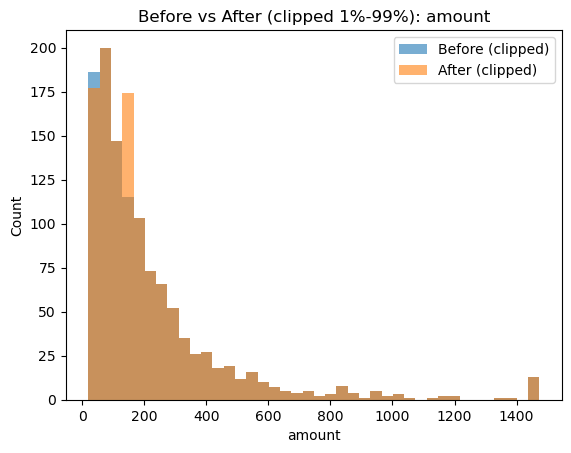

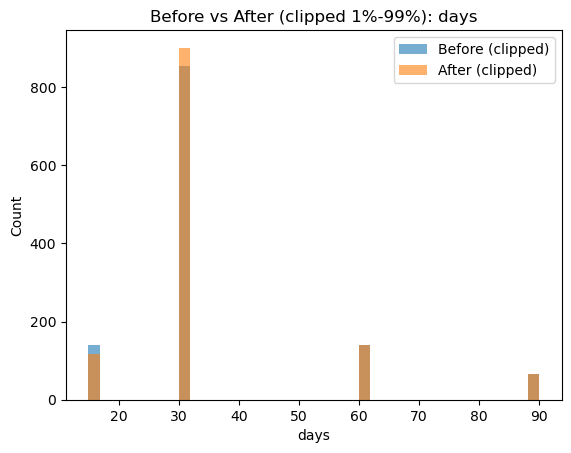

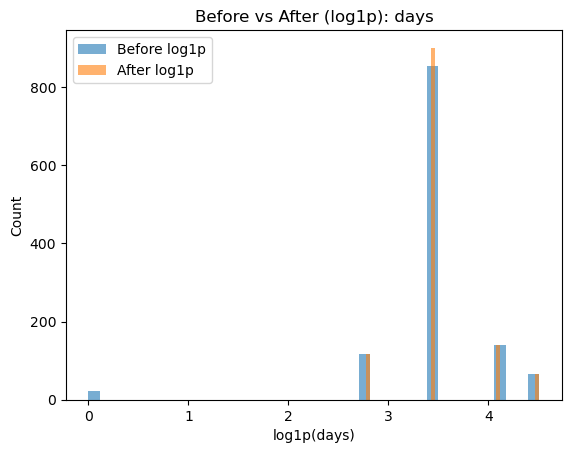

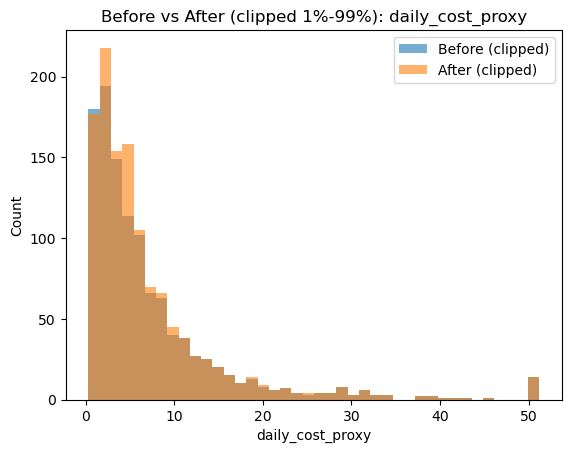

In [21]:
# =========================
# 8) Mini demo on synthetic data (more realistic + clearer visuals)
# =========================
# This synthetic demo stays dataset-agnostic, but is large/realistic enough to produce meaningful plots.
# It intentionally injects:
# - structured missingness by subgroup,
# - "0 encodes missing" style errors,
# - rare negative values (invalid unless reversals),
# - duplicates,
# - and extreme outliers in a heavy-tailed distribution.

rng = np.random.default_rng(7390)

n = 1200
toy = pd.DataFrame({
    "id": np.arange(1, n + 1),
    # Heavy-tailed "paid amount" proxy (lognormal)
    "amount": np.round(rng.lognormal(mean=5.0, sigma=0.9, size=n), 2),
    # DaysSupply-like variable: mostly 30, some 60/90, some 15
    "days": rng.choice([30, 60, 90, 15], size=n, p=[0.72, 0.12, 0.06, 0.10]).astype(float),
    # Subgroup to demonstrate structured missingness / mapping gaps
    "group": rng.choice(["Commercial", "Medicare", "Medicaid"], size=n, p=[0.55, 0.30, 0.15]),
})

# Structured missingness by subgroup (simulate payer/channel mapping gaps)
mask_medicaid = toy["group"].eq("Medicaid")
toy.loc[mask_medicaid & (rng.random(n) < 0.25), "amount"] = np.nan
toy.loc[mask_medicaid & (rng.random(n) < 0.15), "days"] = np.nan

# "0 encodes missing" pattern (common in messy operational datasets)
toy.loc[rng.random(n) < 0.02, "days"] = 0

# Rare invalid negatives (high severity)
toy.loc[rng.random(n) < 0.01, "amount"] *= -1

# A handful of extreme outliers
outlier_idx = rng.choice(toy.index, size=8, replace=False)
toy.loc[outlier_idx, "amount"] *= 50

# Duplicates (simulate accidental double-ingestion)
dup_idx = rng.choice(toy.index, size=25, replace=False)
toy = pd.concat([toy, toy.loc[dup_idx]], ignore_index=True)

# Optional engineered feature (shows how upstream errors can propagate)
toy["daily_cost_proxy"] = np.where(
    toy["days"].notna() & (toy["days"] > 0) & toy["amount"].notna(),
    toy["amount"] / toy["days"],
    np.nan
)

toy_before = toy.copy()
print("Toy demo shape:", toy.shape)
display(toy.head())

# =========================
# DETECT
# =========================
findings = []
findings += duplicate_check(toy, ["id"])
findings += missingness_check(toy, threshold=0.10)
findings += missingness_by_group(toy, "group", ["amount", "days"], threshold=0.20)

num_cols = [c for c in ["amount", "days", "daily_cost_proxy"] if c in toy.columns]
findings += anomaly_score_numeric(toy, num_cols, z_thresh=6.0)

findings += constraint_check(
    toy, "amount_nonnegative",
    lambda d: d["amount"].notna() & (d["amount"] < 0),
    severity=90,
    rec="Negative paid amounts are usually invalid (unless reversals). Set to NaN, flag, and investigate upstream."
)
findings += constraint_check(
    toy, "days_positive",
    lambda d: d["days"].notna() & (d["days"] <= 0),
    severity=85,
    rec="DaysSupply <= 0 often encodes missing/invalid. Replace with NaN, add flag, and fix upstream mapping."
)

report_df = findings_to_frame(findings)
qc_score = aggregate_score(findings)

print("QCScore:", qc_score)
display(report_df.head(25))

# =========================
# FIX (conservative + auditable)
# =========================
fix_log = []
toy_fixed = toy_before.copy()

# Track original missingness separately (before QC-induced NaNs)
toy_fixed["amount__was_missing_original"] = toy_before["amount"].isna().astype(int)
toy_fixed["days__was_missing_original"] = toy_before["days"].isna().astype(int)


toy_fixed["amount__was_invalid_negative"] = (toy_fixed["amount"].notna() & (toy_fixed["amount"] < 0)).astype(int)
toy_fixed.loc[toy_fixed["amount__was_invalid_negative"].eq(1), "amount"] = np.nan

toy_fixed["days__was_nonpositive"] = (toy_fixed["days"].notna() & (toy_fixed["days"] <= 0)).astype(int)
toy_fixed.loc[toy_fixed["days__was_nonpositive"].eq(1), "days"] = np.nan

toy_fixed, log1 = apply_missing_imputation(toy_fixed, "amount", "median", flag_col="amount__was_missing_after_qc")
toy_fixed, log2 = apply_missing_imputation(toy_fixed, "days", "median", flag_col="days__was_missing_after_qc")
fix_log += [log1, log2]

toy_fixed["daily_cost_proxy"] = np.where(
    toy_fixed["days"].notna() & (toy_fixed["days"] > 0) & toy_fixed["amount"].notna(),
    toy_fixed["amount"] / toy_fixed["days"],
    np.nan
)

toy_fixed, log3 = apply_winsorize(toy_fixed, "amount", 0.01, 0.99)
fix_log.append(log3)

print("FixLog:")
display(pd.DataFrame(fix_log))

# =========================
# COMMUNICATE (clearer visuals)
# =========================
def generate_visual_summary_better(df_before: pd.DataFrame, df_after: pd.DataFrame,
                                   numeric_cols: List[str],
                                   clip_q: Tuple[float, float] = (0.01, 0.99),
                                   show_log1p: bool = True) -> None:
    # Better before/after visuals for heavy-tailed data:
    # - Clip to percentile range so one extreme outlier does not dominate the axis.
    # - Optional log1p for non-negative skewed columns.
    for col in numeric_cols:
        if col not in df_before.columns or col not in df_after.columns:
            continue

        b = df_before[col].dropna()
        a = df_after[col].dropna()
        if len(b) == 0 or len(a) == 0:
            continue

        merged = pd.concat([b, a], ignore_index=True)
        lo = np.nanquantile(merged, clip_q[0])
        hi = np.nanquantile(merged, clip_q[1])

        plt.figure()
        plt.hist(b.clip(lo, hi), bins=40, alpha=0.6, label="Before (clipped)")
        plt.hist(a.clip(lo, hi), bins=40, alpha=0.6, label="After (clipped)")
        plt.title(f"Before vs After (clipped {clip_q[0]:.0%}-{clip_q[1]:.0%}): {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend()
        plt.show()

        if show_log1p and (b.min() >= 0) and (a.min() >= 0):
            plt.figure()
            plt.hist(np.log1p(b), bins=40, alpha=0.6, label="Before log1p")
            plt.hist(np.log1p(a), bins=40, alpha=0.6, label="After log1p")
            plt.title(f"Before vs After (log1p): {col}")
            plt.xlabel(f"log1p({col})")
            plt.ylabel("Count")
            plt.legend()
            plt.show()

generate_visual_summary_better(toy_before, toy_fixed, numeric_cols=["amount", "days", "daily_cost_proxy"])


Figure interpretation: The before/after histograms (clipped to the 1st–99th percentiles for readability) show that QC changes only a small fraction of records while preserving the overall shape of each distribution. Amount and daily_cost_proxy remain strongly right-skewed (expected for cost-like variables), but invalid negatives are removed (flagged → set to missing) and extreme tail influence is reduced via winsorization, making the distributions less dominated by rare outliers. Days retains discrete refill-like spikes (15/30/60/90); the log1p(days) view simply re-scales these spikes (and makes 0-values visible on a log scale), highlighting that non-positive encodings were treated as invalid, converted to missing, flagged, and deterministically imputed (median ≈ 30).

---

## Conclusion & Future Work

**What this notebook provides**
- A reusable QC Core implementing **Detect → Fix → Communicate** with deterministic, auditable transformations.
- Clear outputs (findings table, QC score, fix log, visuals) that make data validation reviewable and reproducible.

**Future work**
- **More domain plugins:** Add plugins for other domains (EHR vitals/labs, retail transactions, IoT telemetry, financial time series) so the same QC Core can be reused across more real-world settings.
- **Richer statistical methods:** Expand anomaly detection beyond IQR/MAD to include robust multivariate methods (Isolation Forest, robust covariance / Mahalanobis distance), time-aware drift detection, and subgroup fairness diagnostics.
- **Learning-based QC policies:** Use historical QC outcomes to learn which checks predict downstream failures and auto-tune severity scoring and fix policies.
- **Stronger communication artifacts:** Generate a lightweight QC dashboard (HTML/Markdown) with check summaries, before/after visuals, and an auditable change log.
- **Productionization:** Package QC Core + plugins as a small Python library with config files and CI checks so QC runs automatically on new data drops.


---

## References & License

### Attribution
This project is inspired by a course idea discussed in my professor’s YouTube lecture: that data validation is often ad hoc and that a repeatable system can improve efficiency and trustworthiness. Building on that inspiration, I designed and implemented the QC Core + Plugin architecture and aligned it to the course pillars (preprocessing/validation, computational skepticism, and effective communication).

This notebook was written with assistance from ChatGPT (OpenAI) for wording refinement, structural editing, and code-quality improvements (e.g., clearer error handling and documentation). All final design choices, implementation decisions, and validation logic were reviewed and adapted by me.

### References
- Wickham, H. (2014). *Tidy Data*. Journal of Statistical Software, 59(10). https://www.jstatsoft.org/article/view/v059i10/772  
- Breck, E., Polyzotis, N., Roy, S., Whang, S. E., & Zinkevich, M. (2019). *Data Validation for Machine Learning*. Proceedings of Machine Learning and Systems (MLSys). https://proceedings.mlsys.org/paper_files/paper/2019/hash/928f1160e52192e3e0017fb63ab65391-Abstract.html  
- Great Expectations. (n.d.). *Documentation*. https://docs.greatexpectations.io/docs/home/  
- Knaflic, C. N. (2015). *Storytelling with Data*. Wiley.

### License
- Code in this notebook: MIT License.  
- Datasets: governed by their original Kaggle/source licenses; do not redistribute if prohibited—store only what the assignment allows.
